In [4]:
import ocvx

import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.utils import shuffle

## Partie 1: Méthode de Newton

Avant de commencer à étudier la méthode de Newton, générons des problèmes d'optimisation convexe sans contraintes.

In [2]:
unconstrained = ocvx.getUnconstrainedProblems()

La méthode de Newton est une méthode permettant de résoudre des problèmes d'optimisation convexe. Sa principale différence par rapport à la descente de gradient est l'utilisation de la héssienne de la fonction objectif. Cela fait de la méthode de Newton une méthode de second ordre. Son fonctionnement ayant déjà été expliqué en cours, nous ne la décririons pas dans cette partie.

Problem 0 : quad_1 with constant
x* = [-0.93057262]
Nombre d'itération: 505


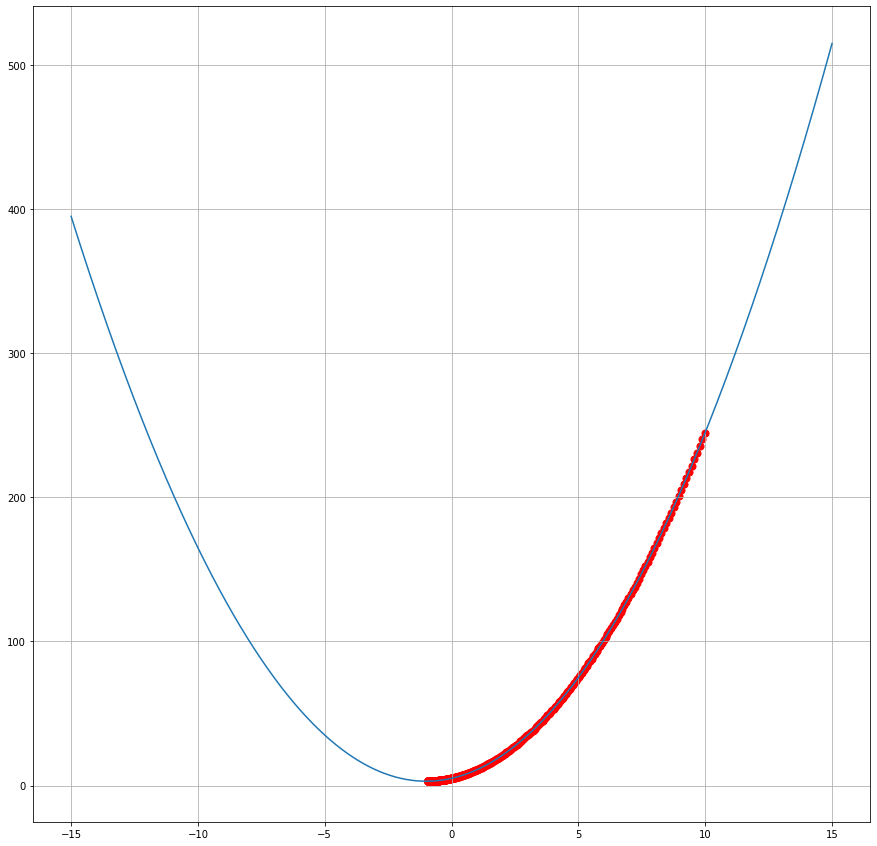

Problem 0 : quad_1 with backtracking
x* = [-0.9665803]
Nombre d'itération: 12


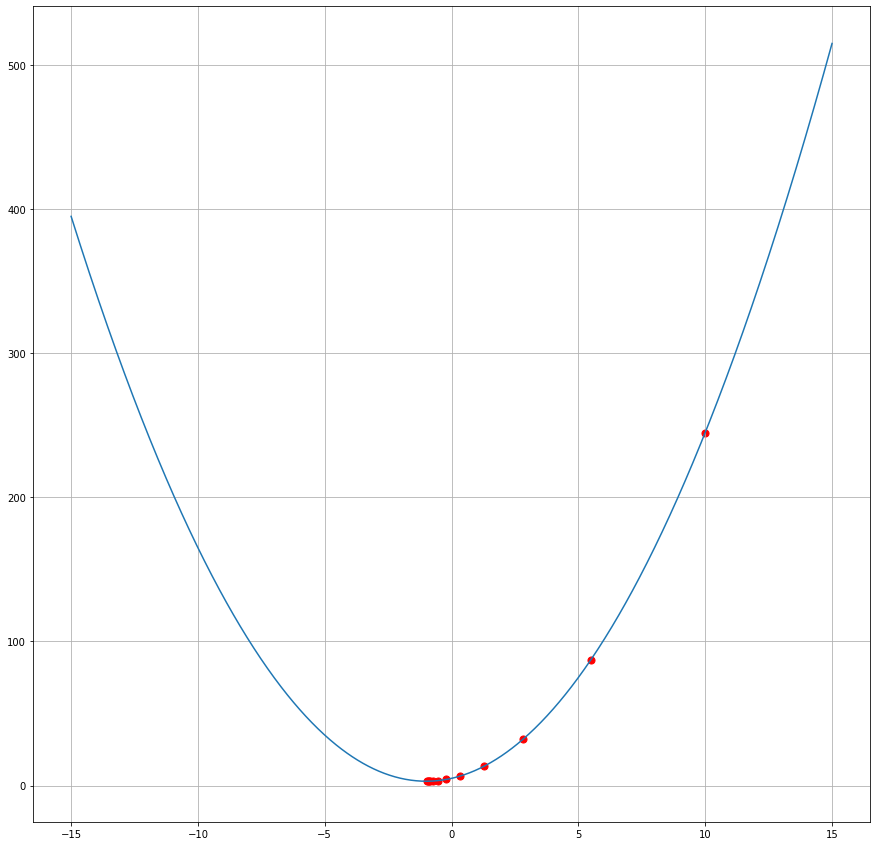

Problem 1 : quad_2 with constant
x* = [ 0.02668479 -0.66317498]
Nombre d'itération: 631


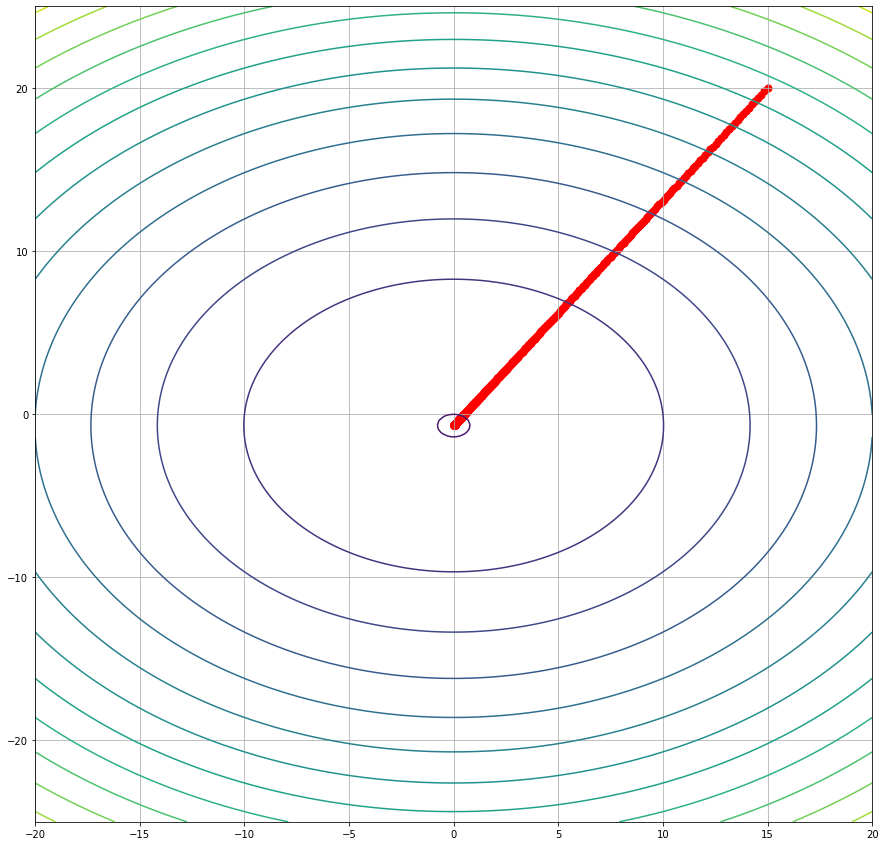

Problem 1 : quad_2 with backtracking
x* = [ 0.02017492 -0.67215861]
Nombre d'itération: 37


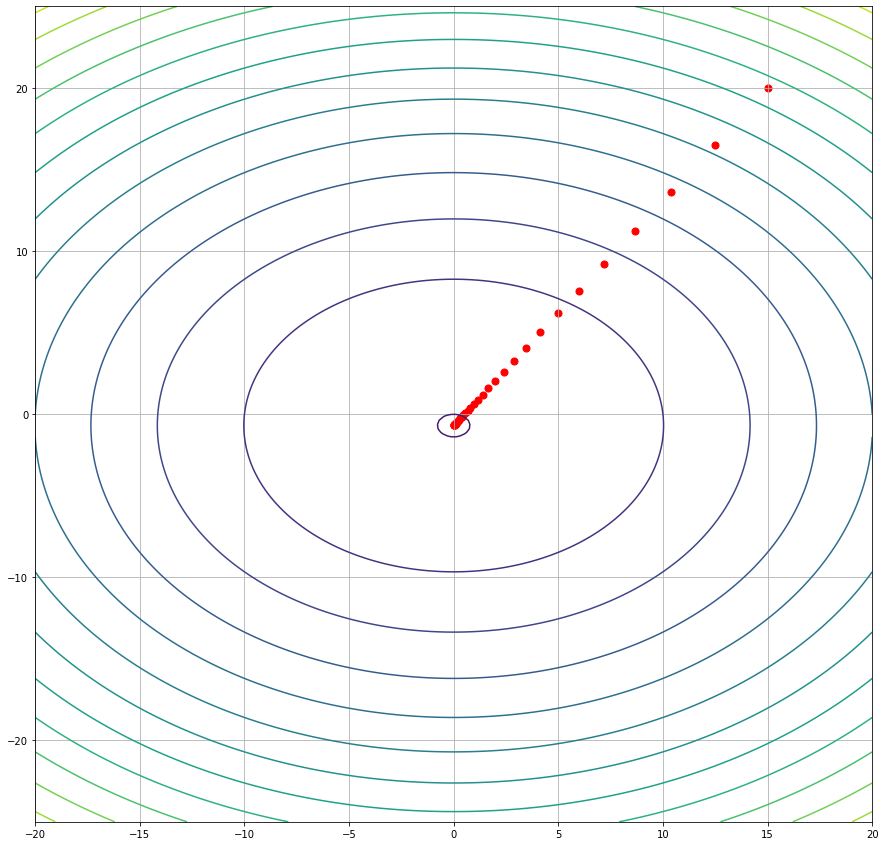

Problem 2 : trigo with constant
x* = [9.49408827]
Nombre d'itération: 206


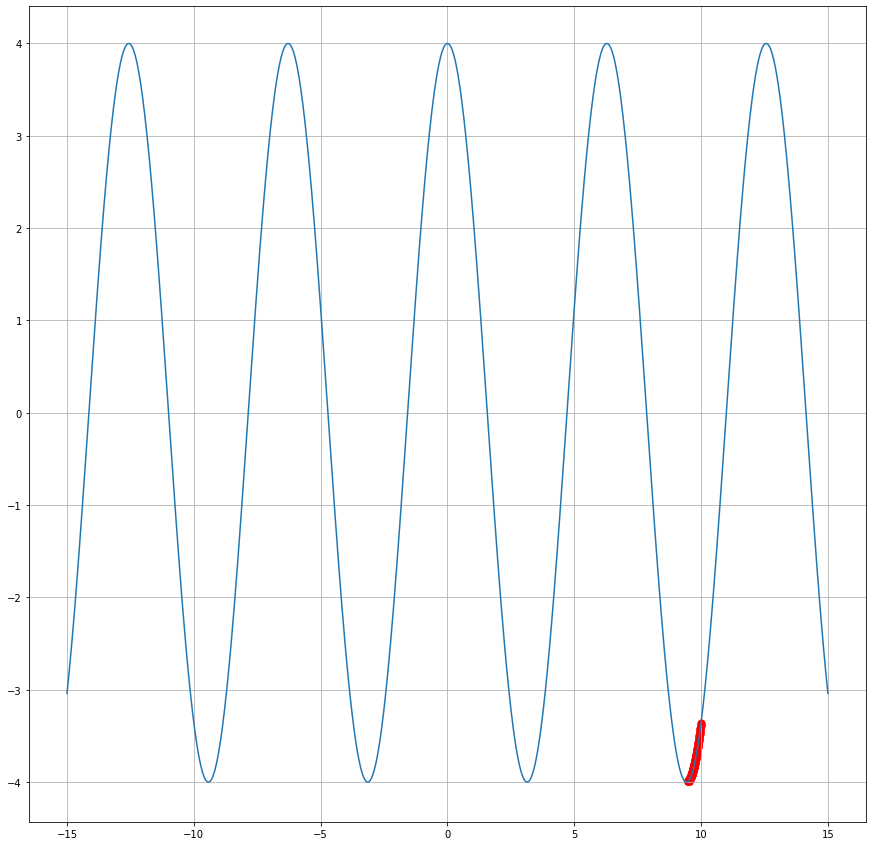

Problem 2 : trigo with backtracking
x* = [9.4611346]
Nombre d'itération: 6


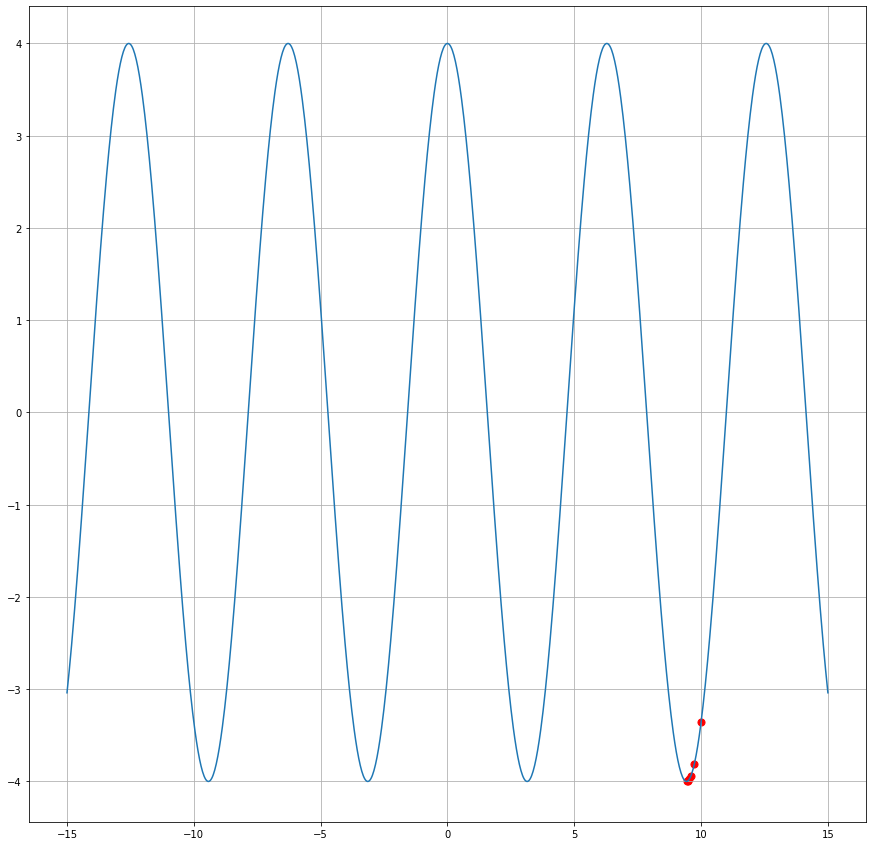

In [9]:
for i in range(unconstrained.shape[0]):
    print("Problem", i, ":", unconstrained.iloc[i]["name"], "with constant")
    P = unconstrained.iloc[i]["probleme"]
    if P.f.dim == 1:
        x0 = np.array([10])
    else:
        x0 = np.array([15, 20])
    meth = ocvx.Newton(P, ocvx.constant)
    print("x* =", meth(x0))
    print("Nombre d'itération:", meth.save.shape[0])
    meth.plot()
    
    print("Problem", i, ":", unconstrained.iloc[i]["name"], "with backtracking")
    meth = ocvx.Newton(P, ocvx.backtracking)
    print("x* =", meth(x0))
    print("Nombre d'itération:", meth.save.shape[0])
    meth.plot()

Sur les graphiques ci-dessus, les points rouges représentent les points à chaque itération de l'algorithme. Pour les fonction en deux dimensions, nous avons choisi de les représenter sous la forme de lignes de niveau. Plus la couleur de la courbe est sombre, plus la valeur de la fonction objectif est petite.

La première observation que l'on peut faire est que la méthode de Newton avec une valeur de pas constant (dans notre cas fixé empiriquement à une valeur de 0.01) est beaucoup plus lente qu'avec une valeur de pas calculée à chaque itération de notre algorithme à l'aide du **backtracking**.

Comparons maintenant la descente de gradient (classique) à la méthode de Newton.

Problem 0 : quad_1 with constant
x* = [-0.99754943]
Nombre d'itération: 207


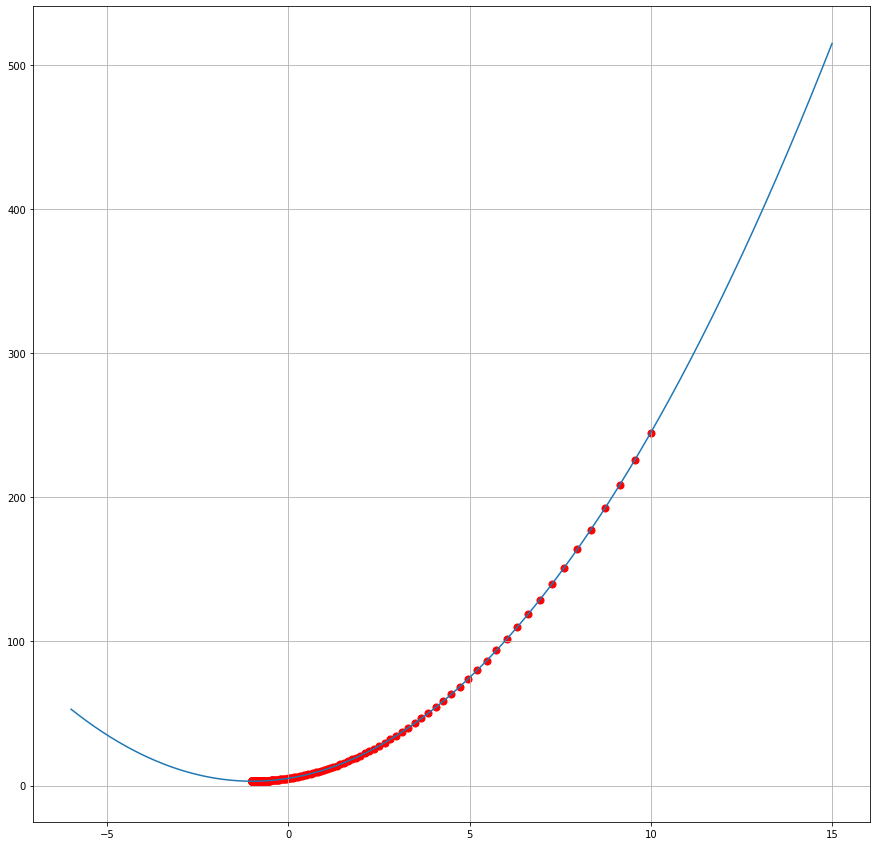

Problem 0 : quad_1 with backtracking
x* = [-1.0021785]
Nombre d'itération: 20


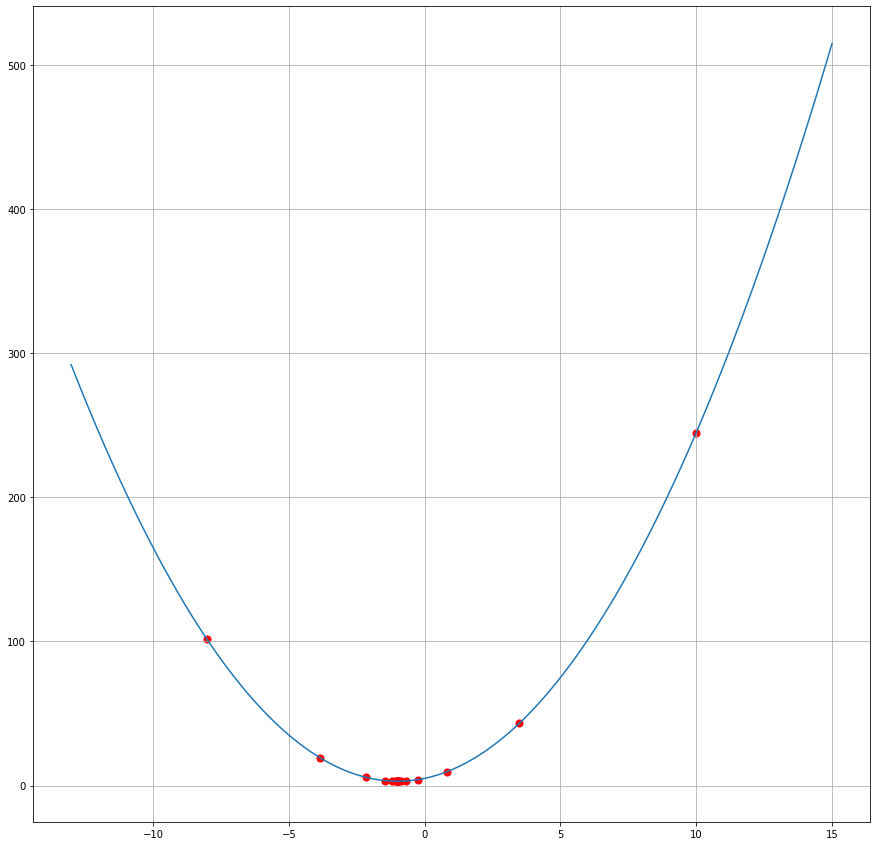

Problem 1 : quad_2 with constant
x* = [ 0.00121371 -0.69986024]
Nombre d'itération: 114


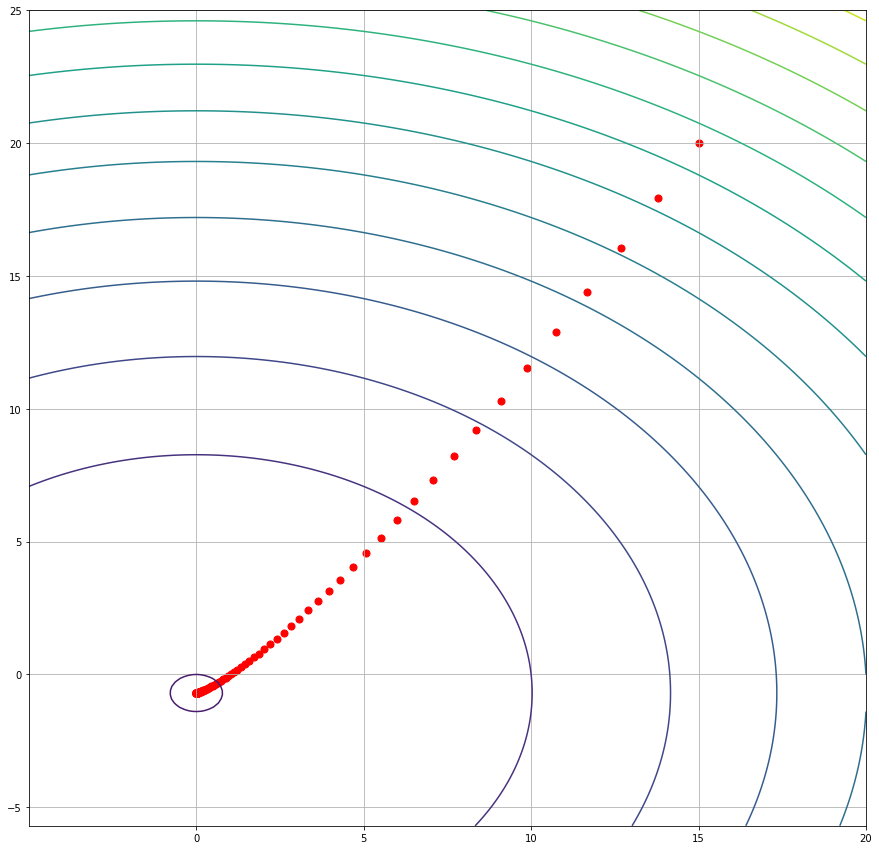

Problem 1 : quad_2 with backtracking
x* = [ 1.16579361e-11 -6.99161883e-01]
Nombre d'itération: 27


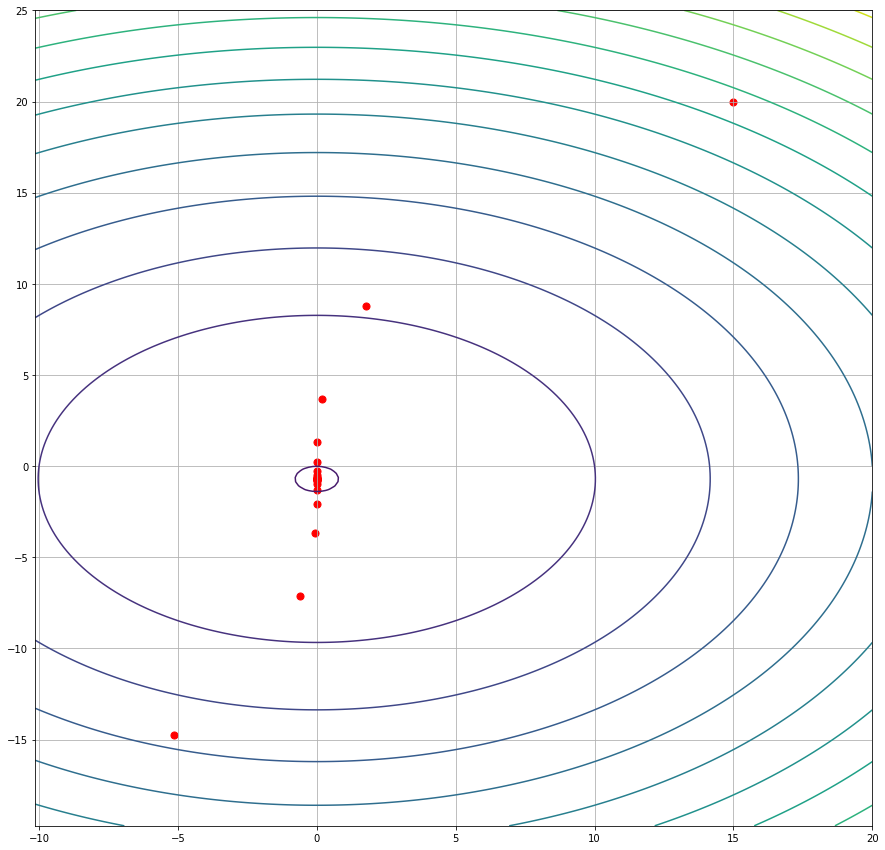

Problem 2 : trigo with constant
x* = [9.42727345]
Nombre d'itération: 135


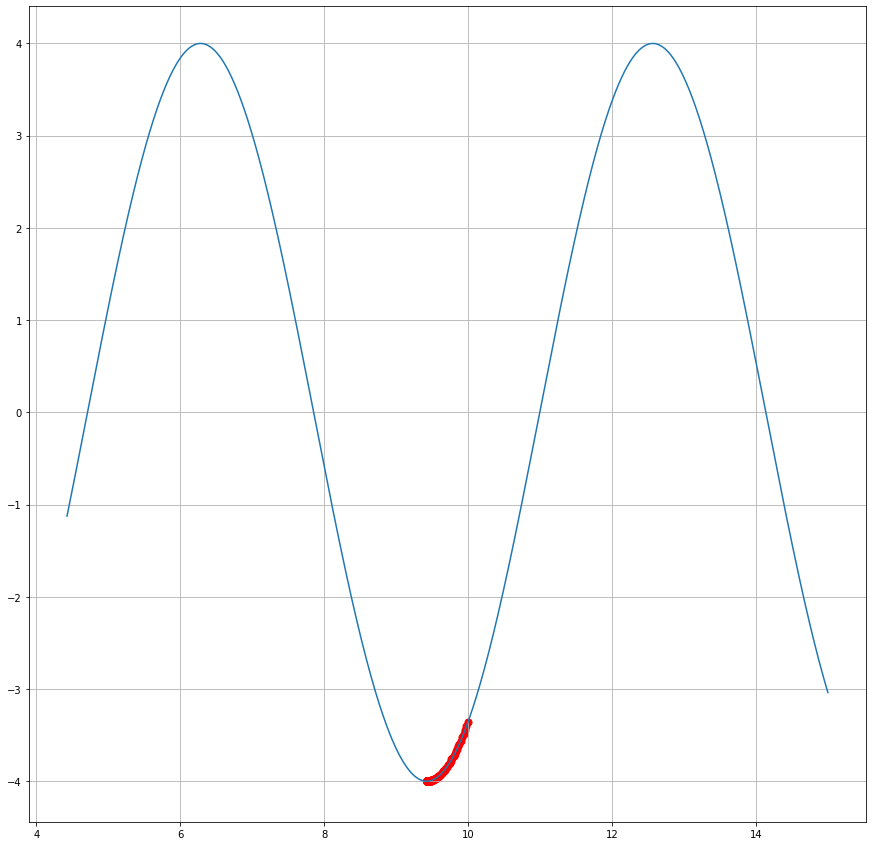

Problem 2 : trigo with backtracking
x* = [9.4268934]
Nombre d'itération: 13


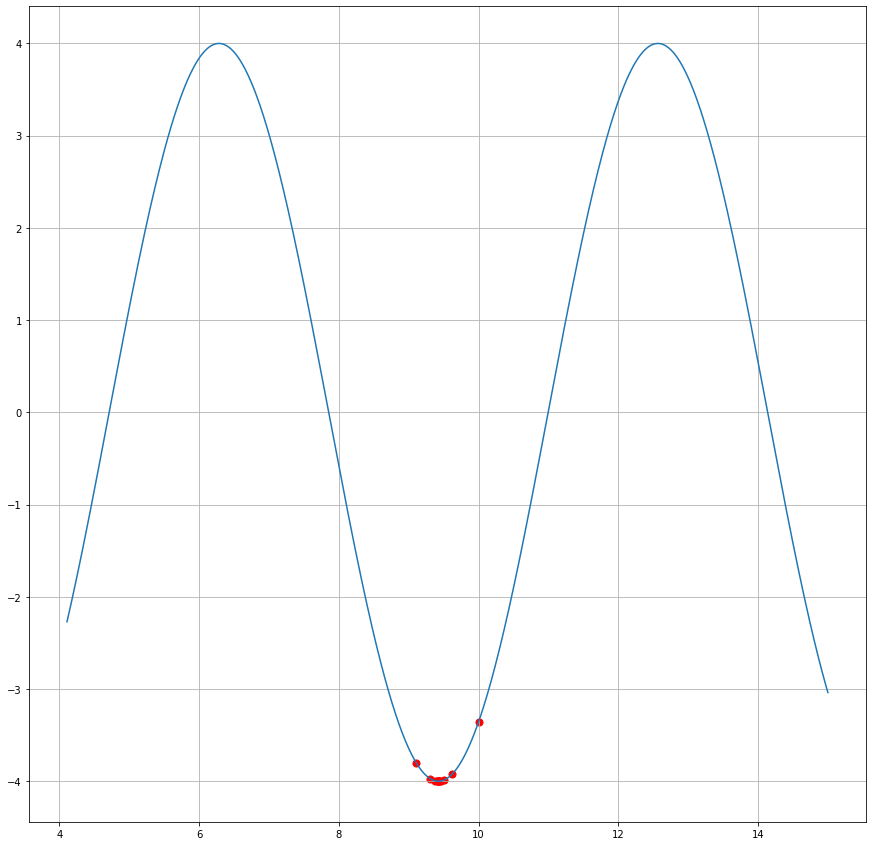

In [10]:
for i in range(unconstrained.shape[0]):
    print("Problem", i, ":", unconstrained.iloc[i]["name"], "with constant")
    P = unconstrained.iloc[i]["probleme"]
    if P.f.dim == 1:
        x0 = np.array([10])
    else:
        x0 = np.array([15, 20])
    meth = ocvx.GradientDescent(P, ocvx.constant)
    print("x* =", meth(x0))
    print("Nombre d'itération:", meth.save.shape[0])
    meth.plot()
    
    print("Problem", i, ":", unconstrained.iloc[i]["name"], "with backtracking")
    meth = ocvx.GradientDescent(P, ocvx.backtracking)
    print("x* =", meth(x0))
    print("Nombre d'itération:", meth.save.shape[0])
    meth.plot()

La méthode de Newton et la descente de gradient présente plusieurs différences plusieurs différences. Premièrement, la descente de gradient avec un pas constant prend moins d'itérations pour minimiser la fonction objectif. Cela est surement dû au fait que la descente de gradient est une méthode de premier ordre qui dépend du gradient alors que la méthode de Newton dépend de la Hessienne.

Ensuite, on observe que la descente de gradient utilisant le backtracking pour le calcul du pas va parfois trop loin et donc nécéssite de retourner en arrière pour minimiser la fonction objectif. On a donc plus d'itération pour la descente de gradient que pour la méthode de Newton en utilisant le backtracking.

## Partie 2: Régularisation de problèmes mal posés

## Préambule

### Un problème mal posé ?

Qu'est-ce-qu'un problème mal posé ? Pour commencer, nous allons définir qu'est ce qu'un problème bien posé. Un problème ($P$) bien posé dit respecter les 3 conditions suivantes:
* Une solution au problème $P$ existe
* La solution est unique
* La solution dépend continuellement de la donnée

Un problème mal posé est un problème ($P$) qui ne respecte pas une des conditions situées au dessus. Il est donc difficile de trouver une solution aux problèmes mal posés avec les méthodes vues auparavant. Pour trouver une solution optimale à ce type de problème nous allons utiliser la méthode analytique des moindres carrés.
Nous utiliserons aussi les méthodes de régularisation telles que LASSO ou Tikhonov.

### La méthode analytique des moindres carrées

#### Principe

Le but de la résolution de la méthode analytique des moindres de carrés est de pouvoir trouver une solution permettant de trouver une relation entre des groupes différents en ajoutant de l'information dans ces données.[BV04]

Plus en détails, on recherche le vecteur $y \in \mathbb{R}^N$ qui contient les éléments {$y_1, y_2, ..., y_n$} où $y_i \in R$. Le vecteur $y$ résulte d'une corrélation des données de la matrice $X$ qui est une matrice $N \times P$ où $P$ représente le nombre de paramètres des éléments $x$. Nous allons en déduire $y$ à l'aide de la formule suivante:
$$
y = X\beta + \epsilon
$$

où
* $\beta$ est vecteur de paramètre qui rajoute l'information dans les données X.
* $\epsilon$ qui représente les résidus (différence entre le point et la droite $y$) aussi appeler erreur de prédiction.

On peut calculer la SSE (Sum of Squared Errors) qui représente la somme de tous les résidus.

$$
SSE(\beta) = \sum_{i}^{N}((y_i - x_i^T\beta)^2)\\
SSE(\beta) = (y - X\beta)^T(y - X\beta)\\
SSE(\beta) = ||y - X\beta||^2_2
$$

La $SSE$ va nous permettre d'appliquer des pénalités à nos données afin de trouver la solution optimale à notre problème.

#### Exemple avec la régression linéaire à 2 dimensions

Soit deux ensembles $E_1$ et $E_2$ de taille $n$ où $\{x_1, x_2, ..., x_n\}$ et $\{y_1, y_2, ... , y_n\}$. $E_1$ et $E_2$ représente des points dans un domaine à 2 dimensions.

on souhaite construire une droite qui séparerait au mieux les deux ensembles $E_1$ et $E_2$.

La méthode des moindres carrés nous permet d'obtenir une droite d'équation du type $y = ax + b$.

Comme montrer au dessus, nous allons calculer la SSE de nos points. La SSE va nous permettre de retrouver les coefficients $a$ et $b$ ppur notre droite objectif $y$.
Ci-dessous la SSE:

$$
SSE = \sum_{i = 0}^{n}{(y_i - (ax_i + b))^2}
$$

Afin d'obtenir la droite pour séparer nos éléments, il faut trouver les valeurs de $a$ et de $b$ à l'aide de la formule de la $SSE$.

#### Démonstration

**Cherchons b**

On a $$SCE = \sum_{i = 0}^{n}{(y_i - (ax_i + b))^2} = \sum_{i = 0}^{n}{(-ax_i - b + y_i)^2}$$

Nous calculons la dérivée partielle en fonction de $b$. Nous considérons $a$ comme une constante

$$
\frac{\partial{SSE}}{\partial{b}} = 0 \iff -2 \sum_{i = 0}^{n}{(-ax_i - b + y_i)} = 0
$$

Nous séparons les deux termes de la somme:

$$
\iff \sum_{i = 0}^{n}{(-ax_i - b)} + \sum_{i = 0}^{n}{y_i} = 0\\
\iff \sum_{i = 0}^{n}{(-ax_i)} - \sum_{i = 0}^{n}{b} + \sum_{i = 0}^{n}{y_i} = 0\\
\iff \sum_{i = 0}^{n}{(-ax_i)} - nb + \sum_{i = 0}^{n}{y_i} = 0\\
\iff -nb = a\sum_{i=0}^{n}{x_i} - \sum_{i = 0}^{n}{y_i}\\
\iff b = -a\frac{\sum{x_i}}{n} + \frac{\sum{y_i}}{n}
$$

On sait que $\frac{\sum{x_i}}{n}$ équivaut à la moyenne de x donc $\frac{\sum{x_i}}{n} = \overline{x}$. De même pour $\frac{\sum{y_i}}{n} = \overline{y}$. Donc:

$$
b = -a\overline{x} + \overline{y}
$$

**Cherchons a**

Avant de calculer la dérivée partielle de $SSE$ en fonction de $a$, nous allons remplacer $b$ dans l'expression de $SSE$

$$
SSE = \sum_{i = 0}^{n}{(-ax_i + a\overline{x} - \overline{y} + y_i)^2}\\
SSE = \sum_{i = 0}^{n}{(-a(x_i - \overline{x}) + (y_i - \overline{y}))^2}
$$

On reconnaît une identité remarquable du type $(a-b)^2 = a^2 - 2ab + b^2$

$$
SSE = \sum_{i=0}^{n}({a^2(x_i - \overline{x})^2}) + 2\sum_{i=0}^{n}({-a(x_i - \overline{x})(y_i - \overline{y})}) + \sum_{i=0}^{n}(y_i - \overline{y})^2
$$

On résout la dérivée partielle de la $SCE$ en fonction de $a$ telle que $\frac{\partial{SCE}}{\partial{a}} = 0$

$$
\iff \sum_{i=0}^{n}({2a(x_i - \overline{x})^2}) - 2 \sum_{i=0}^{n}({(x_i - \overline{x})(y_i - \overline{y})})\\
\iff a = \frac{2\sum_{i=0}^{n}({(x_i - \overline{x})(y_i - \overline{y})}}{2\sum_{i=0}^{n}({(x_i - \overline{x})^2})}\\
$$

Or $\sum_{i=0}^{n}({(x_i - \overline{x})(y_i - \overline{y})} = \sigma_{xy}$ et $\sum_{i=0}^{n}({(x_i - \overline{x})} = \sigma_x$ donc

$$
a = \frac{\sigma_{xy}}{\sigma_{x}^2}
$$

## Les méthodes de régularisation

### Préambule

Comme vu précédemment, la méthode des moindres carrés permet de trouver une corrélation entre des ensembles différents. Nous avons vu la notion de $SSE$ comme étant la somme des résidus. Afin de pouvoir trouver la séparation optimale, il faut trouver un moyen de minimiser la $SSE$. Nous allons utiliser des méthodes de régularisation et de pénalité que nous allons appliquer sur la $SSE$. Au cours de cette question, nous allons présenter les méthodes de régularisation Tikhonov et de LASSO.

On rappelle la $SSE$:

$$
SSE(\beta) = ||y - X\beta||^2_2
$$

où
* $\beta$ est notre ensemble
* $y$ notre fonction objective
* $X$ les points

On définit une pénalité dans le domaine du machine learning (ML) par la minisation de la formule suivante:

$$
arg min \ Pen(\beta) = \mathcal{L}(\beta) + \lambda \Omega(x)
$$

où
* $\mathcal{L}(\beta)$ est la fonction de regression (fonction perte en ML)
* $\lambda$ est le paramètre de régularisation
* $\Omega(\beta)$ est la fonction de pénalité

Les deux méthodes présentent en dessous utilisent deux fonctions de pénalité différentes avec laquelle nous pourrons trouver le vecteur $\beta$ le plus optimal possible à notre problème.

### Les méthodes
#### Tikhonov

Tikhonov (de son vrai non Andreï Nikolaïevitch Tikhonov) est un mathématicien russe. Il est connu pour avoir prouvé la régularisation qui porte son nom. Le but de cette régularisation est d'appliquer une régularisation $\mathcal{L}_2$ comme fonction de pénalité. Cette régularisation s'appelle aussi Ridge[TiK43].

$$
Ridge(\beta) = ||y-X\beta||^{2}_{2} - \lambda ||\beta||^2_2
$$

Afin de pouvoir trouver le $\beta$ minimal, il suffit de résoudre:

$$
\frac{\partial{Ridge}}{\partial{\beta}} = 0
$$

Ce qui nous donne:

$$
\iff\frac{\partial{}}{\partial{\beta}} ((y - X\beta)^T(y - X\beta) + \lambda\beta^T\beta) = 0\\
\iff\frac{\partial{}}{\partial{\beta}} (y^Ty - 2\beta^TX^Ty + \beta^TX^X\beta + \lambda\beta^T\beta) = 0\\
\iff -2X^Ty + 2X^TX\beta + 2\lambda\beta = 0\\
\iff -X^Ty + (X^TX + \lambda)\beta = 0\\
\iff \beta = \frac{X^Ty}{X^TX + \lambda}
$$

#### LASSO

La méthode régularisation de LASSO permet d'appliquer une pénalité $||\beta||_1$ à la méthode de régularisation ce qui donne:


$$
LASSO(\beta) =||y-X\beta||^{2}_{2} + \lambda||\beta||_1
$$

La fonction de pénalité est une régularisation $\mathcal{L}_1$[Tib96].

L'avantage d'utiliser la régularisation de LASSO est de l'utiliser dans le cas où $N < P$. La régularisation $\mathcal{L}_1$ s'adapte mieux que la régularisation $\mathcal{L}_2$ sur ce type de données. Hors il n'est pas adapté dans le cadre de fortes corrélations entre les variables ou si $P$ est très grand par rapport à $n$.

Nous pouvons faire utiliser les deux régularisation en même temps en utilisant Elsatic NET[Hui03].

### Partie implémentation

Nous allons maintenant implémenter la méthodes des moindres carrés avec les deux types de régularisation vues au dessus

In [11]:
class least_square:
    def __init__(self, X):
        self.X = X
        self.beta = np.zeros(X.shape[1])
        self.eps = np.random.randn(X.shape[0])
        
    def run(self):
        self.y = self.X.dot(self.beta) + self.eps 
        return self.y
      
    def compute_SSE(self):
        return np.linalg.norm(self.y - self.X.dot(self.beta), ord=2)**2

    def tikhonov_reg(self, alpha):
        self.beta = np.linalg.inv(np.transpose(self.X).dot(self.X) + np.identity(self.X.shape[1]) * alpha).dot(np.transpose(self.X).dot(self.y))
        self.y = self.X.dot(self.beta) + self.eps
        return self.y

## Partie 3: SVC et SMO

### Principe

Le principe des SVC est de séparer l'espace en deux sous-espaces, celui des échantillons négatifs, et celui des positifs, en aillant la séparation la plus grande possible. Les SVC sont donc assimilés à un problème d'optimisation.

On pose $\vec w$ le vecteur normal à notre hyperplan qui sépare nos échantillons positifs et négatifs. On ne connait pas encore sa longueur. On a aussi un point que l'on veut classifier, représenté par le vecteur $\vec u$. On le projette donc sur $\vec w$, ce qui revient donc à voir notre classification positive comme:

$$
\vec w \cdot \vec u \geqslant C
\iff \vec w \cdot \vec u + b \geqslant 0
$$

avec $C$ et $b$ des constantes.

On pose à nouveau plusieurs contraintes:

$$
\vec w \cdot \vec x_{+} + b \geqslant 1
$$
$$
\vec w \cdot \vec x_{-} + b \leqslant -1
$$

ou $\vec x_{+}$ correspond à un échantillon positif et $\vec x_{-}$ à un négatif.

On introduit $y_{i}$ tel que $y_{i} = 1$ pour un échantillon positif et $y_{i} = -1$ pour un échantillon négatif. En multipliant les équations précédentes par $y_{i}$, on obtient:

$$
y_{i}(\vec w \cdot \vec x_{i} + b) \geqslant 1
$$
$$
\iff y_{i}(\vec w \cdot \vec x_{i} + b) -1 \geqslant 0
$$

Et l'on peut dire des échantillons qui tombent dans la séparation, que:

$$
y_{i}(\vec w \cdot \vec x_{i} + b) -1 = 0
$$

Pour obtenir la largeur de la séparation, il suffit de soustraire un échantillon négatif à un positif et de le multiplier par un vecteur unitair normal à notre hyperplan, comme suit:

$$
width = (\vec x_{+} - \vec x_{-})  \cdot \frac{\vec w}{||\vec w||} = \frac{2}{||\vec w||}
$$

Puisqu'on cherche à avoir la plus grande séparation inter-classe, on cherche donc à maximiser $\frac{2}{||\vec w||}$, ce qui revient à chercher à minimiser $||\vec w||$, ou, pour plus de convénience mathématique, à minimiser $\frac{1}{2}||\vec w||^2$ sujet à $y_{i}(\vec w \cdot \vec x_{i} + b) -1 \geqslant 0$.

En passant par le Lagrangien, on obtient:

$$L = \frac{1}{2}||\vec w||^2 - \sum \alpha_{i} [y_{i}(\vec w \cdot \vec x_{i} + b) - 1]$$

ou $\alpha_{i}$ sont les coefficient multiplicateur du Langrangien. On dérive partiellement par $\vec w$ et $b$.

$$\frac{\partial{L}}{\partial{w}} = 0 \iff \vec w - \sum \alpha_{i} y_{i} \vec x_{i} = 0$$
$$\iff \vec w = \sum \alpha_{i} y_{i} \vec x_{i}$$
$$\frac{\partial{L}}{\partial{b}} = 0 \iff - \sum \alpha_{i} y_{i}= 0$$
$$\iff b = \sum \alpha_{i} y_{i}$$

C'est grâce à ces égalités qu'on va, entre autre, pouvoir implémenter la SMO, ou Sequential Minimal Optimization.

### Implémentation de la SMO

### Principe

La SMO est un algorithme qui permet de résoudre rapidement des problèmes d'optimisation de type SVC QP (quadratic programming) de manière analytique. Cet algorithme se base sur le théorème de Osuna qui assure la convergence en cas de subdivision de problèmes QP en sous problèmes QP.

A chaque étape, on choisit de résoudre le problème d'optimisation le plus petit possible. Celui-ci implique deux coefficients multiplicateurs de Lagrange, $\alpha_{1}$ et $\alpha_{2}$. A chaque étape, ils sont optimisés conjointement pendant que tous les autres coefficients sont conservés identiques, et ainsi de suite jusqu'à convergence. Le choix des coefficients est fait à chaque étape grâce à une heuristique, le but étant de choisir au moins un coefficient ne respectant pas les condition du KKT. Si au moins un des deux coefficients utilisé respecte cette condition, alors le problème est garantit de diminuer, via le théorème de Osuna.

L'implémentation suivante est une version simplifiée de la SMO, avec un choix de coefficients aléatoire.

_[sources: http://cs229.stanford.edu/materials/smo.pdf et https://www.microsoft.com/en-us/research/publication/sequential-minimal-optimization-a-fast-algorithm-for-training-support-vector-machines/]_

In [5]:
class SMO:
    def __init__(self, kernel=None, max_iter=10000, epsilon=0.001, C=1.0):
        if (kernel == None):
            self.kernel = lambda x1, x2 : np.dot(x1, x2.T)
        else:
            self.kernel = kernel
        self.epsilon = epsilon
        self.C = C
        self.max_iter = max_iter
        self.b = None
        self.w = None
    
    '''
    the function that predict the class of an sample thanks to the normal vector w and b
    '''
    def h(self, X):
        return np.sign(np.dot(self.w, X.T) - self.b).astype(int)
    
    '''
    the function that computes the w vector thanks to Lagrange multipliers alpha
    '''
    def compute_w(self, alphas, X, y):
        w = 0
        for i in range(X.shape[0]):
            w += alphas[i] * y[i] * X[i,:]
        self.w = w
    
    def randexclusif(self, mn, mx, excl):
        res = random.randint(mn, mx)
        while (res == excl):
            res = random.randint(mn, mx)
        return res
    
    def fit(self, X, y):
        self.b = 0
        size = (X.shape[0])
        alphas = np.zeros((size))
        for count in range(self.max_iter):
            prev_alphas = np.copy(alphas)
            for i in range(size):
                y1 = y[i]
                x1 = X[i, :]
                alpha1 = alphas[i]
                
                self.compute_w(alphas, X, y)
                Ei = self.h(x1) - y1
                if ((Ei*y1 < -self.epsilon and alpha1 < self.C) or (Ei*y1 > self.epsilon and alpha1 > 0)):
                    #selection of j != i for a simplified SMO method
                    j = self.randexclusif(0, size - 1, i)
                    y2 = y[j]
                    x2 = X[j, :]
                    alpha2 = alphas[j]
                    
                    Ej = self.h(x2) - y2
                    
                    if (y1 == y2):
                        L = max(0, alpha2 + alpha1 - self.C)
                        H = min(self.C, alpha2 + alpha1)
                    else:
                        L = max(0, alpha2 - alpha1)
                        H = min(self.C, self.C + alpha2 - alpha1)
                    
                    if (L == H):
                        continue
                    
                    nu = self.kernel(x1, x1) + self.kernel(x2, x2) - 2 * self.kernel(x1, x2)
                    
                    if (nu < 0):
                        continue
                
                    a2 = alpha2 + float(y2 * (Ei - Ej)) / nu
                    if (a2 > H):
                        a2 = H
                    elif (a2 < L):
                        a2 = L
                    alphas[j] = a2
                    
                    if (abs(a2 - alpha2) < self.epsilon):
                        continue
                    
                    alphas[i] = alpha1 + y1 * y2 * (alpha2 - a2)
                    b1 = Ei + y1 * (alphas[i] - alpha1) * self.kernel(x1, x1) + y2 * (a2 - alpha2) * self.kernel(x1, x2) + self.b
                    b2 = Ej + y1 * (alphas[i] - alpha1) * self.kernel(x1, x2) + y2 * (a2 - alpha2) * self.kernel(x2, x2) + self.b
                    
                    if (alphas[i] > 0 and alphas[i] < self.C):
                        self.b = b1
                    elif (a2 > 0 and a2 < self.C):
                        self.b = b2
                    else:
                        self.b = (b1 + b2) / 2
            diff = np.linalg.norm(alphas - prev_alphas)
            if diff < self.epsilon:
                break
        self.compute_w(alphas, X, y)

    def predict(self, X):
        return self.h(X)

### Fonctions de comparaisons avec un SVC linéaire classique

In [6]:
def generate_problem(size, percent=0.2, linear=True):
    if (linear):
        separable = False
        while not separable:
            samples = make_classification(n_samples=size, n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1, flip_y=-1, weights=[0.5,0.5])
            red = samples[0][samples[1] == 0]
            blue = samples[0][samples[1] == 1]
            separable = any([red[:, k].max() < blue[:, k].min() or red[:, k].min() > blue[:, k].max() for k in range(2)])
    else:
        samples = make_classification(n_samples=size, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=2, flip_y=-1)
        red = samples[0][samples[1] == 0]
        blue = samples[0][samples[1] == 1]
    plt.plot(red[:, 0], red[:, 1], 'r.')
    plt.plot(blue[:, 0], blue[:, 1], 'b.')
    plt.show()
    red = np.array([np.append(red[i], -1) for i in range(len(red))])
    blue = np.array([np.append(blue[i], 1) for i in range(len(blue))])
    perc = int(percent * size)
    trainr = red[:perc]
    testr = red[perc:]
    trainb = blue[:perc]
    testb = blue[perc:]
    res = np.append(trainr, trainb, axis=0)
    res = shuffle(res)
    res2 = np.append(testr, testb, axis=0)
    res2 = shuffle(res)
    X = res[:,:2]
    y = res[:,-1]
    Xtest = res2[:,:2]
    ytest = res2[:,-1]
    return X, y, Xtest, ytest

In [7]:
from sklearn.metrics import f1_score

def compareSVC_SMO(linear=True):
    X, y, Xtest, ytest = generate_problem(1000, 0.2, linear)
    Xall = np.append(X, Xtest, axis=0)
    yall = np.append(y, ytest, axis=0)
    minX = min(Xall[:,0])
    maxX = max(Xall[:,0])
    minX *= 1.2
    maxX *= 1.2
    model = SVC(kernel='linear', C = 1.0)
    model.fit(X, y)
    y_hat_svc = model.predict(X)
    y_hattest_svc = model.predict(Xtest)
    acc = f1_score(y, y_hat_svc)
    acc2 = f1_score(ytest, y_hattest_svc)
    print("accuracy train for SVC:\t%.3f" % (acc))
    print("accuracy test for SVC:\t%.3f" % (acc2))
    w = model.coef_[0]
    
    model2 = SMO()
    model2.fit(X, y)
    y_hat_smo = model2.predict(X)
    y_hattest_smo = model2.predict(Xtest)
    acc = f1_score(y, y_hat_smo)
    acc3 = f1_score(ytest, y_hattest_smo)
    print("accuracy train for SMO:\t%.3f" % (acc))
    print("accuracy test for SMO:\t%.3f" % (acc3))
    w = model2.w
    
    xx = np.linspace(minX,maxX)
    fig, axs = plt.subplots(2, figsize=(20,20))
    fig.suptitle('SVC vs SMO results', fontsize=20)
    
    yy = - 1 * (xx*w[0] + model.intercept_) / w[1]
    yy1 = - 1 * (xx*w[0] + model.intercept_ - 1) / w[1]
    yy2 = - 1 * (xx*w[0] + model.intercept_ + 1) / w[1]
    axs[0].plot(xx, yy, 'k--', label='hyperplan')
    axs[0].plot(xx, yy1, 'k-', label='margin')
    axs[0].plot(xx, yy2, 'k-', label='margin')
    axs[0].scatter(Xall[:, 0], Xall[:, 1], c = yall)
    axs[0].set_title('SVC, accuracy: ' + str(acc2), fontsize=16)
    axs[0].legend(loc='best', fontsize='large')
    
    yy3 = - 1 * (xx*w[0] + model2.b) / w[1]
    yy4 = - 1 * (xx*w[0] + model2.b - 1) / w[1]
    yy5 = - 1 * (xx*w[0] + model2.b + 1) / w[1]
    axs[1].plot(xx, yy3, 'k--', label='hyperplan')
    axs[1].plot(xx, yy4, 'k-', label='margin')
    axs[1].plot(xx, yy5, 'k-', label='margin')
    axs[1].scatter(Xall[:, 0], Xall[:, 1], c = yall)
    axs[1].set_title('SMO, accuracy: ' + str(acc3), fontsize=16)
    axs[1].legend(loc='best', fontsize='large')
    plt.show()

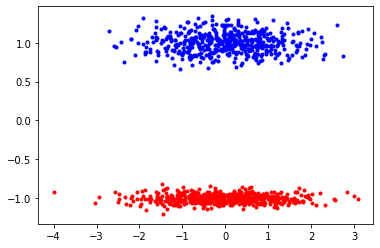

accuracy train for SVC:	1.000
accuracy test for SVC:	1.000
accuracy train for SMO:	1.000
accuracy test for SMO:	1.000


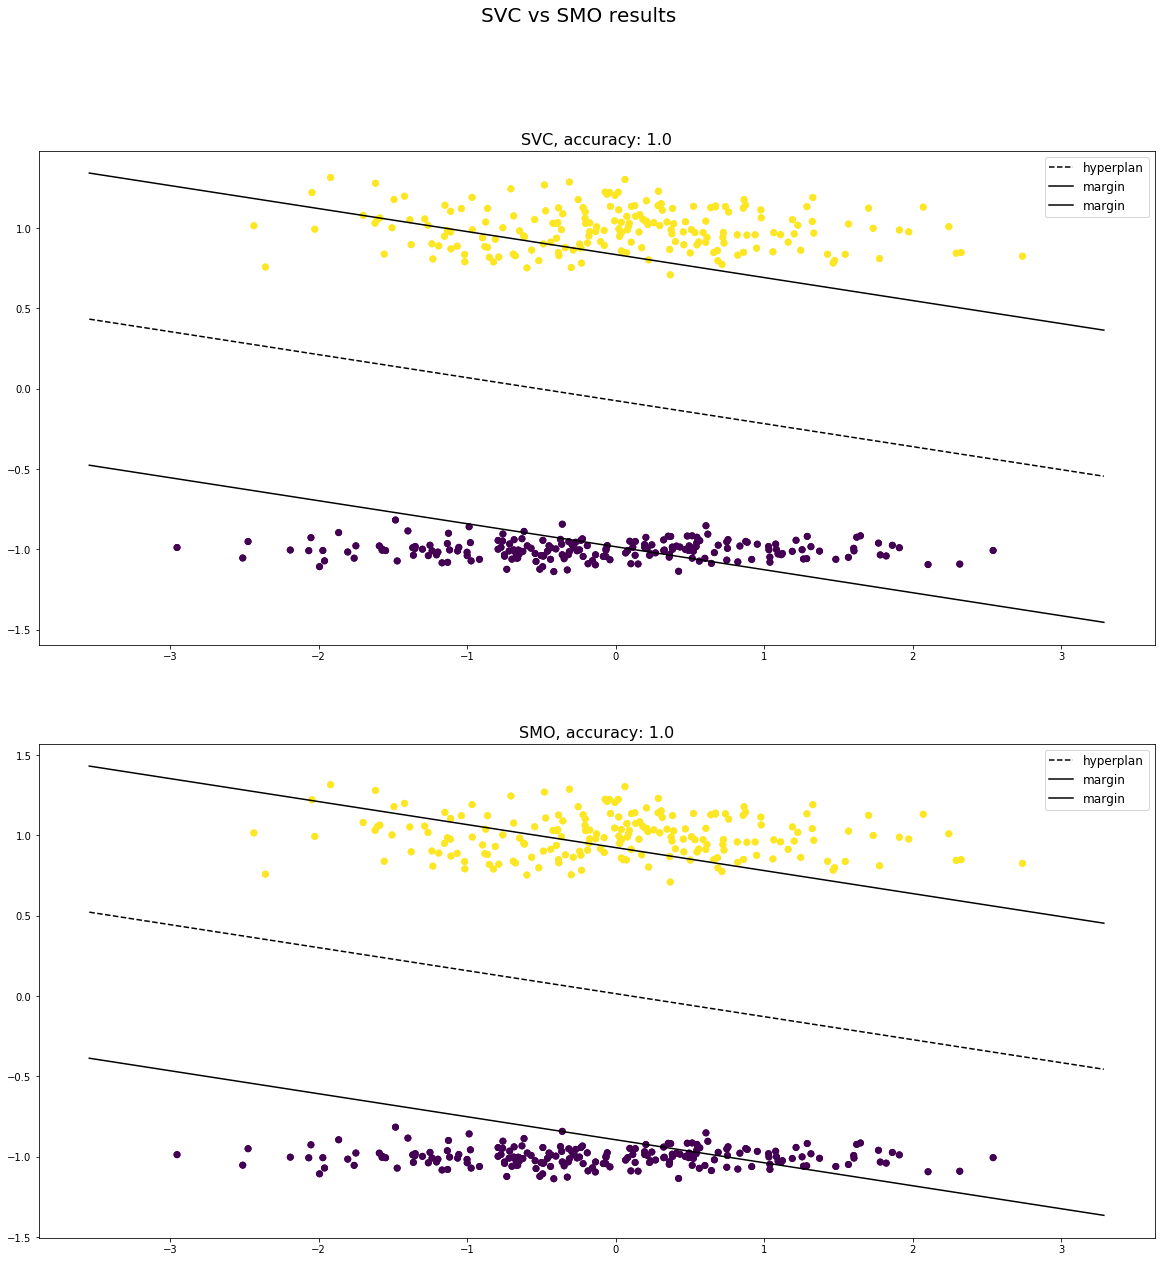

In [8]:
compareSVC_SMO()

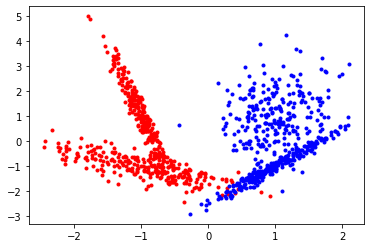

accuracy train for SVC:	0.980
accuracy test for SVC:	0.980
accuracy train for SMO:	0.980
accuracy test for SMO:	0.980


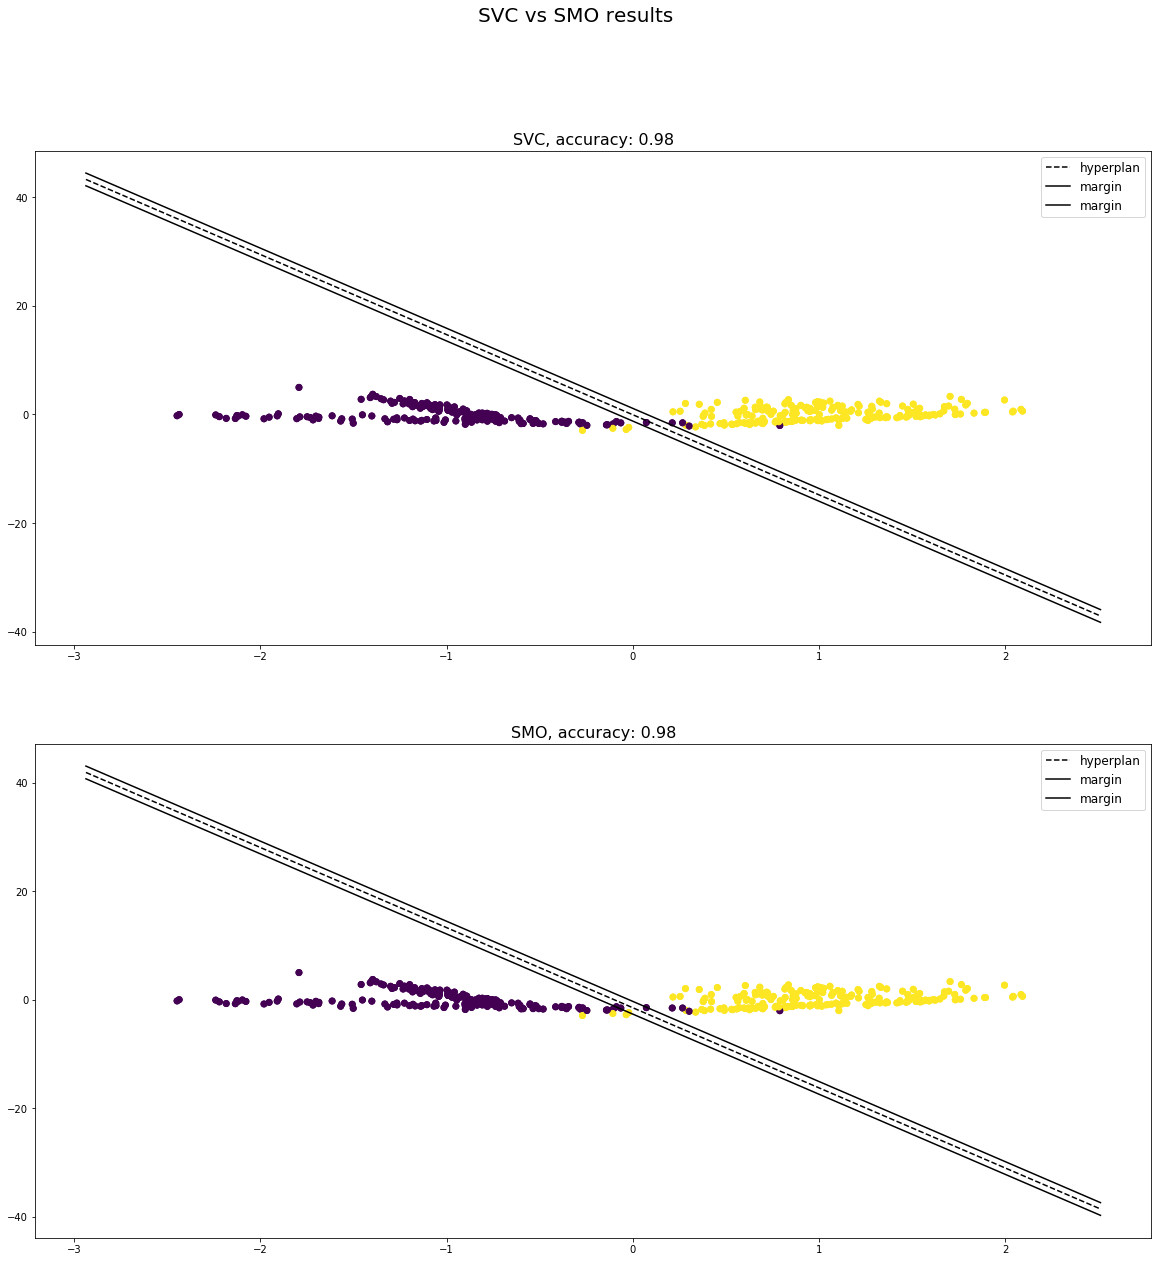

In [9]:
compareSVC_SMO(False)